In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

import config
from dataset import OCRDataset
from model import OCRResNet18, OCRUNet18
import utils

In [2]:
root_dir = '../../data/komonjo/200003076/'
path_to_annotation_csv = root_dir + '200003076_coordinate.csv'
original_image_dir = root_dir + 'images/'
resized_image_dir = root_dir + 'images_resized_' + str(config.RESIZE_IMAGE_SIZE) + '/'

In [3]:
preprocessed_annotation = utils.preprocess_annotation(path_to_annotation_csv, original_image_dir)

utf16_to_index, index_to_utf16 = utils.make_maps_between_index_and_frequent_characters_utf16(preprocessed_annotation, 
                                                                                             config.N_KINDS_OF_CHARACTERS)

selected_annotation = utils.select_annotation_and_convert_ut16_to_index(preprocessed_annotation, utf16_to_index)

train_annotation_list, validation_annotation_list = train_test_split(selected_annotation[:250],
                                                                     test_size=0.2,
                                                                     random_state=config.RANDOM_SEED)

tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = OCRDataset(resized_image_dir, train_annotation_list, transform=tf)
validation_dataset = OCRDataset(resized_image_dir, validation_annotation_list, transform=tf)
test_dataset = OCRDataset(resized_image_dir, selected_annotation[250:], transform=tf)


batchsize = 20
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

In [4]:
def show_result(image, bboxes):
    color_map = ['red', 'green', 'blue', 'yellow', 'purple', 'brown', 'pink', 'cyan', 'orange', 'black']
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    for char_index, bboxes_per_class in enumerate(bboxes):
        confidence, center_x, center_y, width, height = bboxes_per_class
        min_x = center_x - 0.5*width
        min_y = center_y - 0.5*height
        for idx, (mx, my, w, h) in enumerate(zip(min_x, min_y, width, height)):
            if idx == 0:
                rect = patches.Rectangle(xy=(mx, my), width=w, height=h, 
                                         fill=False, edgecolor=color_map[char_index], label=index_to_utf16[char_index])
            else:
                rect = patches.Rectangle(xy=(mx, my), width=w, height=h, 
                                         fill=False, edgecolor=color_map[char_index])
            # rect = patches.Rectangle(xy=(mx, my), width=w, height=h, 
            #                         fill=False, edgecolor=[char_index/255, char_index/255, char_index/255])        
        ax.add_patch(rect)
    plt.legend(bbox_to_anchor=(1.3, 1))
    image_for_show = np.transpose(image.numpy(), [1, 2, 0])*0.5 + 0.5
    plt.imshow(image_for_show)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = OCRUNet18(5*config.N_KINDS_OF_CHARACTERS, pretrained=True)
net = net.to(device)
params = torch.load(root_dir + 'logs/20190310/weight_300.pth')
net.load_state_dict(params)

RuntimeError: Error(s) in loading state_dict for OCRUNet18:
	Missing key(s) in state_dict: "unet.encoder1.downsampler.0.weight", "unet.encoder1.downsampler.0.bias", "unet.encoder1.downsampler.1.weight", "unet.encoder1.downsampler.1.bias", "unet.encoder1.downsampler.1.running_var", "unet.encoder1.downsampler.1.running_mean", "unet.encoder2.downsampler.0.weight", "unet.encoder2.downsampler.0.bias", "unet.encoder2.downsampler.1.weight", "unet.encoder2.downsampler.1.bias", "unet.encoder2.downsampler.1.running_var", "unet.encoder2.downsampler.1.running_mean", "unet.encoder3.downsampler.0.weight", "unet.encoder3.downsampler.0.bias", "unet.encoder3.downsampler.1.weight", "unet.encoder3.downsampler.1.bias", "unet.encoder3.downsampler.1.running_var", "unet.encoder3.downsampler.1.running_mean", "unet.encoder4.downsampler.0.weight", "unet.encoder4.downsampler.0.bias", "unet.encoder4.downsampler.1.weight", "unet.encoder4.downsampler.1.bias", "unet.encoder4.downsampler.1.running_var", "unet.encoder4.downsampler.1.running_mean", "unet.decoder1.upsampler.0.weight", "unet.decoder1.upsampler.0.bias", "unet.decoder2.upsampler.0.weight", "unet.decoder2.upsampler.0.bias", "unet.decoder2.upsampler.1.weight", "unet.decoder2.upsampler.1.bias", "unet.decoder2.upsampler.1.running_var", "unet.decoder2.upsampler.1.running_mean", "unet.decoder3.upsampler.0.weight", "unet.decoder3.upsampler.0.bias", "unet.decoder3.upsampler.1.weight", "unet.decoder3.upsampler.1.bias", "unet.decoder3.upsampler.1.running_var", "unet.decoder3.upsampler.1.running_mean", "unet.decoder4.upsampler.0.weight", "unet.decoder4.upsampler.0.bias", "unet.decoder4.upsampler.1.weight", "unet.decoder4.upsampler.1.bias", "unet.decoder4.upsampler.1.running_var", "unet.decoder4.upsampler.1.running_mean". 
	size mismatch for additional_layers.0.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 3, 3]).
	size mismatch for additional_layers.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for additional_layers.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for additional_layers.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for additional_layers.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for additional_layers.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for additional_layers.3.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 3, 3]).
	size mismatch for additional_layers.3.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for additional_layers.4.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for additional_layers.4.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for additional_layers.4.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for additional_layers.4.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for additional_layers.6.weight: copying a param with shape torch.Size([50, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([50, 1024, 1, 1]).

In [ ]:
train_images, train_labels = iter(train_loader).next()
validation_images, validation_labels = iter(validation_loader).next()
test_images, test_labels = iter(test_loader).next()

net.eval()
with torch.no_grad():
    train_preds = net(train_images.to(device)).detach().cpu()
    validation_preds = net(validation_images.to(device)).detach().cpu()
    test_preds = net(test_images.to(device)).detach().cpu()

index = 4
gt_train_bboxes = train_dataset.label2bboxes(train_labels[index])
gt_validation_bboxes = validation_dataset.label2bboxes(validation_labels[index])
gt_test_bboxes = test_dataset.label2bboxes(test_labels[index])

pred_train_bboxes = train_dataset.label2bboxes(train_preds[index], confidence_border=0.5)
pred_validation_bboxes = validation_dataset.label2bboxes(validation_preds[index])
pred_test_bboxes = test_dataset.label2bboxes(test_preds[index])

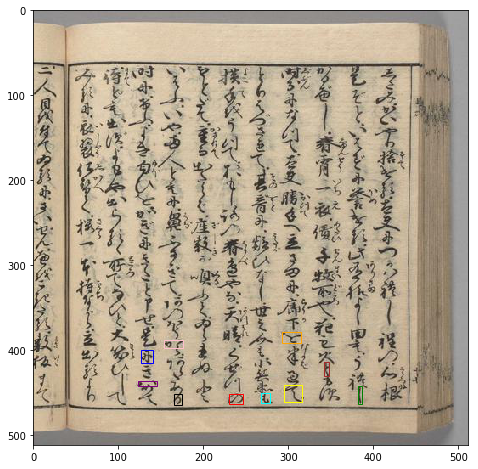

In [26]:
show_result(train_images[index], gt_train_bboxes)

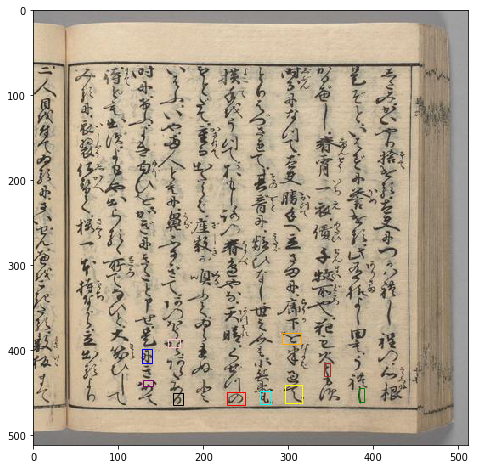

In [27]:
show_result(train_images[index], pred_train_bboxes)

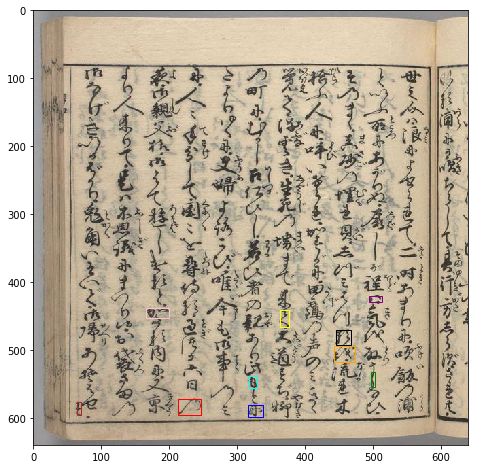

In [21]:
show_result(validation_images[index], gt_validation_bboxes)

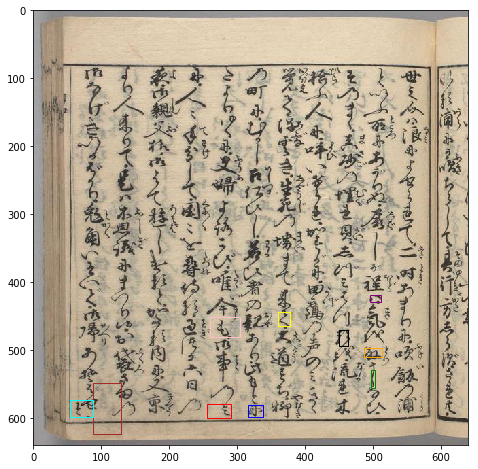

In [22]:
show_result(validation_images[index], pred_validation_bboxes)

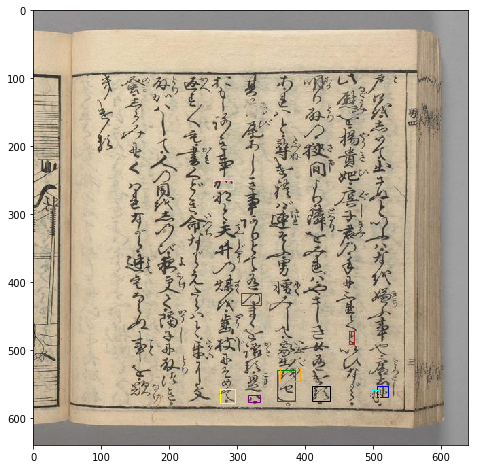

In [23]:
show_result(test_images[index], gt_test_bboxes)

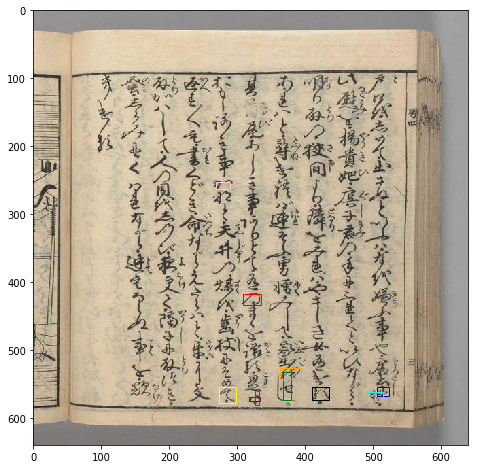

In [24]:
show_result(test_images[index], pred_test_bboxes)

In [29]:
train_loader.dataset.